In [87]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

import word2vec
from data_loader import load_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils import plot_confusion_matrix
from utils import timeSince

import time

In [88]:
dim_word2vec = 50
seq_length = 15

#CNN parameters
filter_sizes = [2, 3, 4, 5, 6, 7, 10]
num_filter = 100
fc_input_size = len(filter_sizes) * num_filter
fc_hd_size = 200
dropout_p = 0.5


batch_size = 16
epochs = 15
learning_rate = 1e-4
model_fn = '../results/rnn_tc/rnn_tc_LSTM.11180355.pt'

In [89]:
# glov_wv = word2vec.load_wv('../data/word2vec/glove.twitter.27B/word2vec.%dd.txt' % dim_word2vec)
glov_wv = word2vec.load_wv_from_model('../data/word2vec/retrained_word2vec/reddit_word2vec')

loading word2vec...


In [90]:
data_train, label_train = load_data('../data/train.csv')
data_test, label_test = load_data('../data/test.csv')

#check number of labels in each class
tmp = label_test.tolist()
for label in np.unique(label_test):
    print('{}: {}'.format(label, tmp.count(label)))

tmp2 = label_train.tolist()
for label in np.unique(label_train):
    print('{}: {}'.format(label, tmp2.count(label)))

def avg_length(sentences):
    N = len(sentences)
    all_length = 0
    for sentence in sentences:
        all_length += len(sentence)

    return all_length / N    

def txt2vector(sentences, dic, dim, pad_length=14):
    vectors = []
    count = 0
    
    for sentence in sentences:
        vector = []
        for word in word2vec.preprocess(sentence[0]):
            if len(vector) < pad_length and word in dic:
                vector.append(dic[word])
            
            if word not in dic:
                count += 1
        
        while len(vector) < pad_length:
            vector.append(np.ones(dim))
            
        vectors.append(vector)
        
    print('missing words: %d, avg missing words: %f' % (count, count / sentences.shape[0]))
    return np.array(vectors)

data_train_vec = txt2vector(data_train, glov_wv, dim_word2vec, seq_length)
data_test_vec = txt2vector(data_test, glov_wv, dim_word2vec, seq_length)

all_categories = np.unique(label_train).tolist()
print('categories:', all_categories)

def label2vector(labels, all_categories):
    return np.array([all_categories.index(label) for label in labels])

label_train_vec = label2vector(label_train, all_categories)
label_test_vec = label2vector(label_test, all_categories)

education: 1020
politics: 1084
science: 1036
sports: 1000
education: 4065
politics: 4356
science: 4147
sports: 4000
missing words: 22601, avg missing words: 1.364136
missing words: 5691, avg missing words: 1.374638
categories: ['education', 'politics', 'science', 'sports']


In [91]:
class CNN(nn.Module):
    def __init__(self, seq_length ,embedding_size, filter_sizes, num_filter, fc_input_size, fc_hd_1, n_class, dropout_p):
        super(CNN, self).__init__()
        self.num_filter = num_filter
        self.filter_sizes = filter_sizes
        self.embedding_size = embedding_size
        self.num_filters_total = len(self.filter_sizes) * num_filter
        
        self.in_channel = 1
        self.out_channel = num_filter

        self.convs = []
        self.pools = []
        for filter_size in filter_sizes:            
            self.convs.append(nn.Conv2d(self.in_channel, self.out_channel, (filter_size, embedding_size)))
            self.pools.append(nn.MaxPool2d((seq_length-filter_size+1, 1), stride=1))
        
        self.fc = nn.Linear(fc_input_size, fc_hd_1)
        self.fc_hd = nn.Linear(fc_hd_1, n_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, is_train):
        pooled_inputs = []
        for conv, pool in zip(self.convs, self.pools):
            conved_input = conv(input)
            pooled_input = pool(conved_input)
            pooled_inputs.append(pooled_input)
#         print('pooled_input:', pooled_inputs[0].shape)
#         print(pooled_inputs[0])        
        output = torch.cat(pooled_inputs, 3)
#         print('output_1:', output.shape)
#         print(output)
        output = torch.reshape(output, (-1, self.num_filters_total))       
#         print('output_2:', output.shape)        
#         print(output)                
        output = self.fc(output)
#         print('output_3:', output.shape)        
        output = self.relu(output)
        if is_train:
            output = self.dropout(output)

        output = self.fc_hd(output)                
        output = self.softmax(output)
        return output

In [92]:
def batch_iter(X, y, batch_size=64, shuffle=True):
    N = len(X)
    num_batch = int((N - 1) / batch_size) + 1
    
    if shuffle:
        indices = np.random.permutation(np.arange(N))
        X_shuffle = X[indices]
        y_shuffle = y[indices]
    else:
        X_shuffle = X
        y_shuffle = y
    
    for i in range(num_batch):
        start_idx = i * batch_size
        end_idx = min((i+1) * batch_size, N)
        yield torch.tensor(X_shuffle[start_idx: end_idx], dtype=torch.float), torch.tensor(y_shuffle[start_idx: end_idx])

In [93]:
n_class = len(all_categories)
n_training = len(data_train)

model = CNN(seq_length, dim_word2vec, filter_sizes, num_filter, fc_input_size, fc_hd_size, n_class, dropout_p)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.NLLLoss()

losses = []

start = time.time()
min_loss = 1e+5

for epoch in range(epochs):
    scheduler.step()
    idx = 0
    for X_batch, y_batch in batch_iter(data_train_vec, label_train_vec, batch_size):
        cur_batch_size = y_batch.size()[0]
        X_batch = X_batch.reshape((cur_batch_size, 1, seq_length, dim_word2vec))
        
        output = model(X_batch, True)
#         print(output.shape)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)        
        optimizer.step()        
        
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model, model_fn)
        
#         assert False
        idx += 1
        
        if idx % 100 == 0:
            losses.append(loss.item())
            print('%s, %d epoch, %d index, %f loss' % (timeSince(start),epoch, idx, loss.item()))            
        

/Users/zhengcao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/zhengcao/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0m 1s, 0 epoch, 100 index, 1.096478 loss
0m 2s, 0 epoch, 200 index, 0.856560 loss
0m 3s, 0 epoch, 300 index, 0.969634 loss
0m 4s, 0 epoch, 400 index, 0.836765 loss
0m 5s, 0 epoch, 500 index, 0.489768 loss
0m 6s, 0 epoch, 600 index, 0.548059 loss
0m 7s, 0 epoch, 700 index, 0.531808 loss
0m 8s, 0 epoch, 800 index, 0.573103 loss
0m 9s, 0 epoch, 900 index, 0.227603 loss
0m 10s, 0 epoch, 1000 index, 0.455321 loss
0m 11s, 1 epoch, 100 index, 0.266824 loss
0m 12s, 1 epoch, 200 index, 0.506444 loss
0m 13s, 1 epoch, 300 index, 0.423296 loss
0m 14s, 1 epoch, 400 index, 0.374564 loss
0m 15s, 1 epoch, 500 index, 0.371462 loss
0m 16s, 1 epoch, 600 index, 0.306352 loss
0m 17s, 1 epoch, 700 index, 0.492866 loss
0m 18s, 1 epoch, 800 index, 0.226487 loss
0m 19s, 1 epoch, 900 index, 0.367979 loss
0m 20s, 1 epoch, 1000 index, 0.586333 loss
0m 21s, 2 epoch, 100 index, 0.443070 loss
0m 23s, 2 epoch, 200 index, 0.181299 loss
0m 24s, 2 epoch, 300 index, 0.124898 loss
0m 25s, 2 epoch, 400 index, 0.670457 loss

3m 15s, 19 epoch, 500 index, 0.194300 loss
3m 16s, 19 epoch, 600 index, 0.311235 loss
3m 17s, 19 epoch, 700 index, 0.091995 loss
3m 18s, 19 epoch, 800 index, 0.269517 loss
3m 19s, 19 epoch, 900 index, 0.209438 loss
3m 20s, 19 epoch, 1000 index, 0.501170 loss


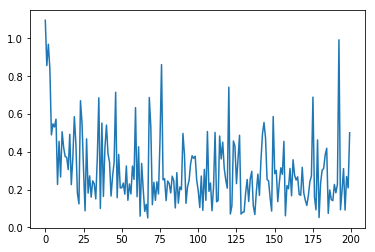

In [94]:
plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.show()

/Users/zhengcao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix, without normalization
[[909  38  49  24]
 [ 38 986  22  38]
 [ 48  23 938  27]
 [ 33  37  26 904]]


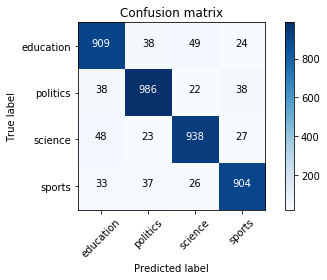

              precision    recall  f1-score   support

   education       0.88      0.89      0.89      1020
    politics       0.91      0.91      0.91      1084
     science       0.91      0.91      0.91      1036
      sports       0.91      0.90      0.91      1000

   micro avg       0.90      0.90      0.90      4140
   macro avg       0.90      0.90      0.90      4140
weighted avg       0.90      0.90      0.90      4140



In [95]:
def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

def test(X, y, y_vec):
    model = torch.load(model_fn)
    
    y_preds = []
    for X_batch, y_batch in batch_iter(X, y_vec, 1, False):

        cur_batch_size = y_batch.size()[0]
        X_batch = X_batch.reshape((cur_batch_size, 1, seq_length, dim_word2vec))

        output = model(X_batch, False)
        for r in output:
            y_preds.append(category_from_output(r, all_categories))

    cnf_matrix = confusion_matrix(y, y_preds)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=all_categories, title='Confusion matrix')
    plt.show()

    print(classification_report(y, y_preds))
    
test(data_test_vec, label_test, label_test_vec)
# test(data_train_vec, label_train, label_train_vec)